# Air Pollution in Myanmar
This notebook analyzes air pollution in Myanmar using data from the Sentinel-5 Precursor (Sentinel-5p) satellite, specifically the TROPOMI (Tropospheric Monitoring Instrument) sensor. Sentinel-5p TROPOMI provides high-resolution, daily measurements of atmospheric trace gases, including nitrogen dioxide (NO₂), ozone (O₃), carbon monoxide (CO), methane (CH₄), and more.

For this analysis, we use the NO₂ column number density product, which quantifies the total amount of nitrogen dioxide in a vertical column of the atmosphere above each location. The data is processed to aggregate values at various administrative levels (ADM0–ADM3) and over different time periods (annual, monthly).
Key features of the Sentinel-5p TROPOMI dataset:
- **Global coverage** with a spatial resolution of up to 3.5 x 5.5 km.
- **Daily revisit** frequency, enabling near real-time monitoring.
- **Open access** via the Copernicus program, supporting research and policy.

The NO₂ data is joined to Myanmar administrative boundaries using spatial operations, and year-over-year (YoY) changes are computed to assess trends and anomalies. This approach enables robust, scalable analysis of air quality at national and subnational levels.
For more details on the Sentinel-5p mission and TROPOMI instrument, see:
- [ESA Sentinel-5p Mission Overview](https://sentinel.esa.int/web/sentinel/missions/sentinel-5p)
- [TROPOMI Data User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-5p-tropomi)

Air Pollution is typically measured by calculating the density of different pollutants in the atmosphere. Some of the commonly measured pollutants are NO2, O3 and particulate matter. Studies found NO2 levels as a useful proxy for economic activity (Deb, et.al., 2020). One of the reasons is because it is measured during the day when businesses are open and people are at work. It also stays close to the source of emissions —such as engines, vehicles or chimneys — and has a short atmospheric life (Ezran, et.al., 2023). Yailymova et.al., 2023 also posited that air quality and, in particular, levels of fine particulate matter (e.g., PM2.5 and PM 10 ) over cities can be a proxy for assessment of economic activity and density of city populations. NO2 along with other NOx reacts with other chemicals in the air to form both particulate matter and ozone. A 2020 study of cities in Sub-Saharan Africa finds that NO2 provides a useful, albeit “noisy”, real-time proxy measure of how COVID-19 has affected [economic activity](https://blogs.worldbank.org/developmenttalk/what-nitrogen-dioxide-emissions-tell-us-about-fragile-recovery-south-asia).

In this analysis, we observe the trends in monthly NO2 levels for Ethiopia from 2019 to 2024. The methodology to link economic activity to NO2 is still ongoing. This analysis is one step of it. 

## Common sources of NO2

- One of the chemical processes that generates NO2 is burning of fossil fuels (coal, gas and oil). Gives cars use this process, road traffic is the principal outdoor source of nitrogen dioxide (Jarvis et. al., 2010). 
- Diesel powered non-road equipment
- Industrial processes such as oil and gas production
- Coal fired power plants
- While the principal emissions of an aircraft are CO2 and H2O, other major emissions include nitric oxide and nitrogen dioxide (Miake-Lye & Hauglustaine, 2022).
- Any construction activity involving diesel fuel non-road mobile machinery will result in NOx emissions. 

In [2]:
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
DATA_FOLDER = Path('../../data/')
NO2_FOLDER = DATA_FOLDER / 'airpollution'
BOUNDARY_FOLDER = DATA_FOLDER / 'boundaries'

In [69]:
mmr_adm0 = gpd.read_file(BOUNDARY_FOLDER/'mmr_polbnda_adm0_250k_mimu_20240215.shp')
mmr_adm1 = gpd.read_file(BOUNDARY_FOLDER/'mmr_polbnda_adm1_250k_mimu_20240215.shp')
mmr_adm2 = gpd.read_file(BOUNDARY_FOLDER/'mmr_polbnda_adm2_250k_mimu_20240215.shp')
mmr_adm3 = gpd.read_file(BOUNDARY_FOLDER/'mmr_polbnda_adm3_250k_mimu_20240215.shp')
mmr_adm4 = gpd.read_file(BOUNDARY_FOLDER/'mmr_polbnda_adm4_250k_mimu_20240215.shp')
ind = gpd.read_file(BOUNDARY_FOLDER/'industrial__special_economic_zones_sept2019.shp')

In [5]:
mmr_no2 = pd.read_csv(NO2_FOLDER/'myanmar_no2.csv')

In [44]:
unique_points = mmr_no2[['latitude', 'longitude']].drop_duplicates()

In [45]:
unique_points = gpd.GeoDataFrame(unique_points,
                                    geometry=gpd.points_from_xy(unique_points.longitude, unique_points.latitude))
unique_points.crs = "EPSG:4326"

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# Your sjoin result with duplicate points on borders
merged = unique_points[['geometry', 'latitude', 'longitude']].sjoin(
    mmr_adm3[['ADM3_PCODE', 'geometry']], 
    how='inner', 
    predicate='intersects'
)

# For points that matched multiple polygons, pick the one where point is furthest from boundary
def pick_deepest_polygon(group):
    """For a point matching multiple polygons, pick the one furthest from the boundary"""
    if len(group) == 1:
        return group
    
    point = group.iloc[0].geometry
    
    # Calculate distance from point to each polygon's boundary
    distances = []
    for idx, row in group.iterrows():
        poly = row['geometry']
        # Distance to boundary (negative if outside, but we're inside so it's positive)
        dist_to_boundary = point.distance(poly.boundary)
        distances.append(dist_to_boundary)
    
    # Return the row with maximum distance to boundary (deepest inside)
    deepest_idx = distances.index(max(distances))
    return group.iloc[[deepest_idx]]

# Group by the original point index and pick the deepest polygon for each
result = merged.groupby(level=0, group_keys=False).apply(pick_deepest_polygon)

print(f"Original matches: {len(merged)}, After deduplication: {len(result)}")
print(result[['latitude', 'longitude', 'ADM3_PCODE']].head())

Original matches: 721745, After deduplication: 721734
    latitude  longitude ADM3_PCODE
0  23.639167  97.076441  MMR001013
1  23.639167  97.085424  MMR001013
2  23.648150  97.013559  MMR001013
3  23.648150  97.022542  MMR001013
4  23.648150  97.031525  MMR001013


In [9]:
mmr_no2 = mmr_no2.merge(
    result[['latitude', 'longitude', 'ADM3_PCODE']], 
    on=['latitude', 'longitude'], 
    how='left'
)

In [10]:
mmr_no2_adm3 = mmr_no2.groupby(['ADM3_PCODE', 'year', 'start_date'])['NO2_column_number_density'].mean().reset_index()

In [70]:
# Create 10km buffer around each industrial zone point
# First convert to a projected CRS for accurate distance calculations (UTM Zone 46N for Myanmar)
ind_projected = ind.to_crs('EPSG:32646')

# Create 10km buffer (10000 meters)
ind_buffered = ind_projected.copy()
ind_buffered['geometry'] = ind_projected.geometry.buffer(5000)

# Convert back to geographic CRS for consistency with other datasets
ind_buffered = ind_buffered.to_crs('EPSG:4326')

<Axes: >

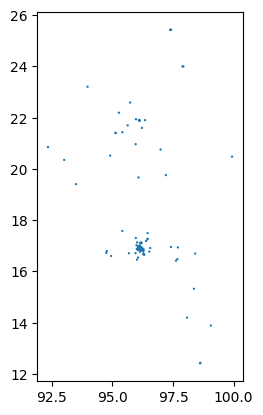

In [ ]:
ind_buffered.to_file

In [56]:
mmr_no2_ind = unique_points[['geometry', 'latitude', 'longitude']].sjoin(
    ind_buffered[['geometry', 'Name']], 
    how='inner', 
    predicate='intersects'
)

mmr_no2_ind = mmr_no2_ind.groupby(level=0, group_keys=False).apply(pick_deepest_polygon)

In [57]:
mmr_no2_ind = mmr_no2.merge(
    mmr_no2_ind[['latitude', 'longitude', 'Name']],
    on =['latitude', 'longitude'],
    how='right'
)

In [64]:
mmr_no2_adm3[['ADM3_EN', 'ADM3_MY', 'ADM3_PCODE', 'ADM2_EN', 'ADM2_MY', 'ADM2_PCODE',
       'ADM1_EN', 'ADM1_MY', 'ADM1_ALTPC', 'ADM1_PCODE', 'year', 'start_date',
       'NO2_column_number_density']].to_csv(NO2_FOLDER/'myanmar_no2_adm3.csv', index=False)

In [65]:
mmr_no2_ind.to_csv(NO2_FOLDER/'myanmar_no2_industrial_zones.csv', index=False)


In [11]:
mmr_no2_adm3 = mmr_adm3.merge(
    mmr_no2_adm3,
    on='ADM3_PCODE')

In [12]:
mmr_no2_adm2 = mmr_no2_adm3.groupby(['ADM2_PCODE', 'year', 'start_date'])['NO2_column_number_density'].mean().reset_index()
mmr_no2_adm1 = mmr_no2_adm3.groupby(['ADM1_PCODE', 'year', 'start_date'])['NO2_column_number_density'].mean().reset_index()

In [13]:
mmr_no2_adm0 = mmr_no2.groupby(['year', 'start_date'])['NO2_column_number_density'].mean().reset_index()

In [14]:
import numpy as np
import pandas as pd

def compute_yoy_annual(df, value_col, year_col='year', group_cols=None, out_col='pct_change_yoy'):
    """
    Compute YoY percent change using annual values.

    Parameters
    ----------
    df : pd.DataFrame
        Input data containing at least `year_col` and `value_col`.
    value_col : str
        Column with the numeric values to compare.
    year_col : str, default 'year'
        Column with integer year.
    group_cols : list[str] | None, default None
        Optional grouping columns (e.g., ['ADM3_PCODE']). Use [] for no groups.
    out_col : str, default 'pct_change_yoy'
        Output column name for percentage change.

    Returns
    -------
    pd.DataFrame
        Copy of input with an added `out_col` that is the percent change vs
        previous year within each group (or overall if no groups).
    """
    if group_cols is None:
        group_cols = []
    work = df.copy()
    # Ensure types
    work[year_col] = pd.to_numeric(work[year_col], errors='coerce').astype('Int64')
    work[value_col] = pd.to_numeric(work[value_col], errors='coerce')
    # Sort for stable pct_change
    work = work.sort_values(group_cols + [year_col])
    # Compute pct change within groups (or globally when no groups)
    if len(group_cols) == 0:
        work[out_col] = work[value_col].pct_change(periods=1) * 100.0
        prev = work[value_col].shift(1)
    else:
        work[out_col] = (
            work.groupby(group_cols)[value_col]
                .pct_change(periods=1) * 100.0
        )
        prev = work.groupby(group_cols)[value_col].shift(1)
    # Avoid division artifacts when previous year is 0 or NaN
    work.loc[(prev == 0) | prev.isna(), out_col] = np.nan
    return work

def compute_yoy_monthly(df, value_col, date_col='start_date', group_cols=None, out_col='pct_change_yoy'):
    """
    Compute YoY percent change for monthly series by aligning months across years.

    For each (group, month), compares current year vs previous year same month.
    """
    if group_cols is None:
        group_cols = []
    work = df.copy()
    work[date_col] = pd.to_datetime(work[date_col], errors='coerce')
    work[value_col] = pd.to_numeric(work[value_col], errors='coerce')
    work['year'] = work[date_col].dt.year
    work['month'] = work[date_col].dt.month
    # Sort for stable pct_change
    work = work.sort_values(group_cols + ['month', 'year'])
    work[out_col] = (
        work.groupby(group_cols + ['month'])[value_col]
            .pct_change(periods=1) * 100.0
    )
    prev = work.groupby(group_cols + ['month'])[value_col].shift(1)
    work.loc[(prev == 0) | prev.isna(), out_col] = np.nan
    return work
    

In [15]:
mmr_no2_annual = mmr_no2_adm0.groupby(['year'])['NO2_column_number_density'].mean().reset_index()

In [16]:
mmr_no2_annual = compute_yoy_annual(mmr_no2_annual, 'NO2_column_number_density', group_cols=None)

In [17]:
yangon_no2 = mmr_no2_adm1[mmr_no2_adm1['ADM1_EN'] =='Yangon']

KeyError: 'ADM1_EN'

In [ ]:
mmr_no2_adm1 = mmr_adm1.merge(mmr_no2_adm1, on='ADM1_PCODE', how='inner')
mmr_no2_adm2 = mmr_adm2.merge(mmr_no2_adm2, on='ADM2_PCODE', how='inner')
#mmr_no2_adm3 = mmr_adm3.merge(mmr_no2_adm3, on='ADM3_PCODE', how='inner')

In [ ]:
mmr_no2_adm1_annual = mmr_no2_adm1.groupby(['ADM1_PCODE','year', 'ADM1_EN'])['NO2_column_number_density'].mean().reset_index()
mmr_no2_adm1_annual = compute_yoy_annual(mmr_no2_adm1_annual, 'NO2_column_number_density', group_cols=['ADM1_PCODE', 'ADM1_EN'])


## Trend in NO2 Change Annually


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

def plot_adm1_yoy(df, adm1_names=None, adm1_codes=None, year_col='year', 
                  adm1_name_col='ADM1_EN', 
                  adm1_code_col='ADM1_PCODE', 
                  yoy_col='pct_change_yoy', 
                  title='NO2 YoY change by ADM1', palette='tab10', annotate_last=False):
    """
    Plot YoY percentage change lines for selected ADM1 regions.

    Parameters
    ----------
    df : DataFrame
        Data with columns [year_col, adm1_name_col, adm1_code_col, yoy_col].
    adm1_names : list[str] | None
        Names to include (matched against adm1_name_col).
    adm1_codes : list[str] | None
        Codes to include (matched against adm1_code_col).
    year_col, adm1_name_col, adm1_code_col, yoy_col : str
        Column names in df.
    title : str
        Plot title.
    palette : str | list, default 'tab10'
        Seaborn/matplotlib palette name or list of colors.
    annotate_last : bool, default False
        If True, annotate the latest point for each series with its label.
    """
    if adm1_names is None and adm1_codes is None:
        raise ValueError('Provide either adm1_names or adm1_codes')
    # Clean theme
    sns.set_theme(style='whitegrid', context='notebook')

    # Filter
    filt = pd.Series(True, index=df.index)
    if adm1_names:
        filt &= df[adm1_name_col].isin(adm1_names)
    if adm1_codes:
        filt &= df[adm1_code_col].isin(adm1_codes)
    data = df.loc[filt].copy()
    if data.empty:
        raise ValueError('No rows match the provided ADM1 filters')

    # Sort for consistent plotting
    data = data.sort_values([adm1_name_col, year_col])

    # Plot
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.lineplot(
        data=data, x=year_col, y=yoy_col, hue=adm1_name_col,
        marker='o', linewidth=2, alpha=0.95, dashes=False, palette=palette, ax=ax
    )
    ax.axhline(0, color='0.4', linewidth=1, linestyle='--', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('YoY change (%)')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.grid(True, axis='y', alpha=0.3)
    ax.margins(x=0.02, y=0.1)
    for spine in ax.spines.values():
        spine.set_alpha(0.3)
    ax.legend(title='ADM1', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

    if annotate_last:
        # annotate last available point for each series
        last_points = (
            data.dropna(subset=[yoy_col])
                .sort_values(year_col)
                .groupby(adm1_name_col)
                .tail(1)
        )
        for _, row in last_points.iterrows():
            ax.text(
                row[year_col], row[yoy_col], f" {row[adm1_name_col]}",
                va='center', ha='left', fontsize=9, alpha=0.9
            )

    plt.tight_layout()
    plt.show()

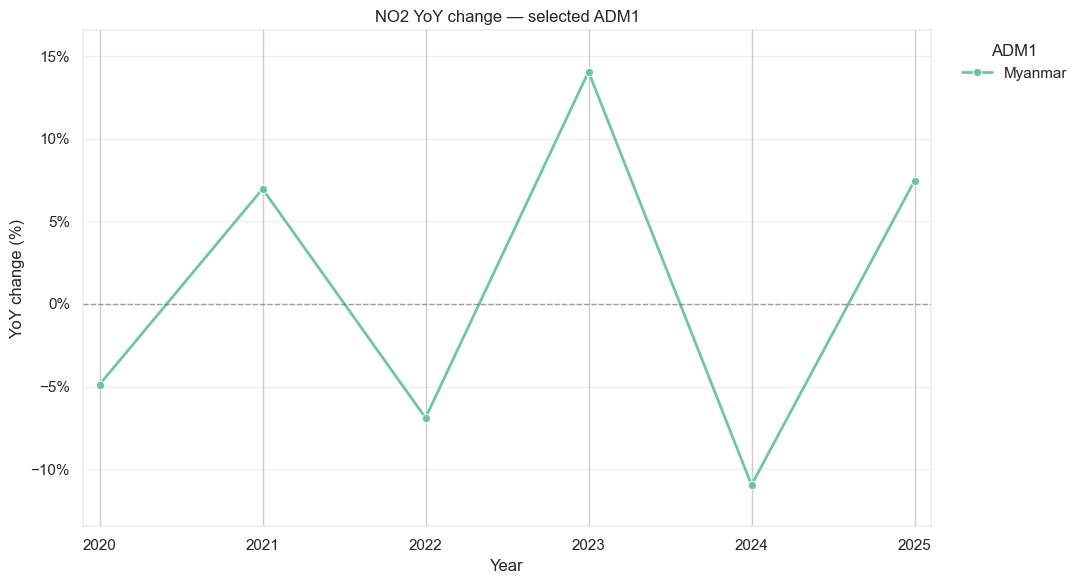

In [ ]:
plot_adm1_yoy(
    mmr_no2_annual, adm1_names=['Myanmar'], yoy_col='pct_change_yoy',
    adm1_code_col='country',adm1_name_col='country',
    title='NO2 YoY change — selected ADM1', palette='Set2', annotate_last=False
)

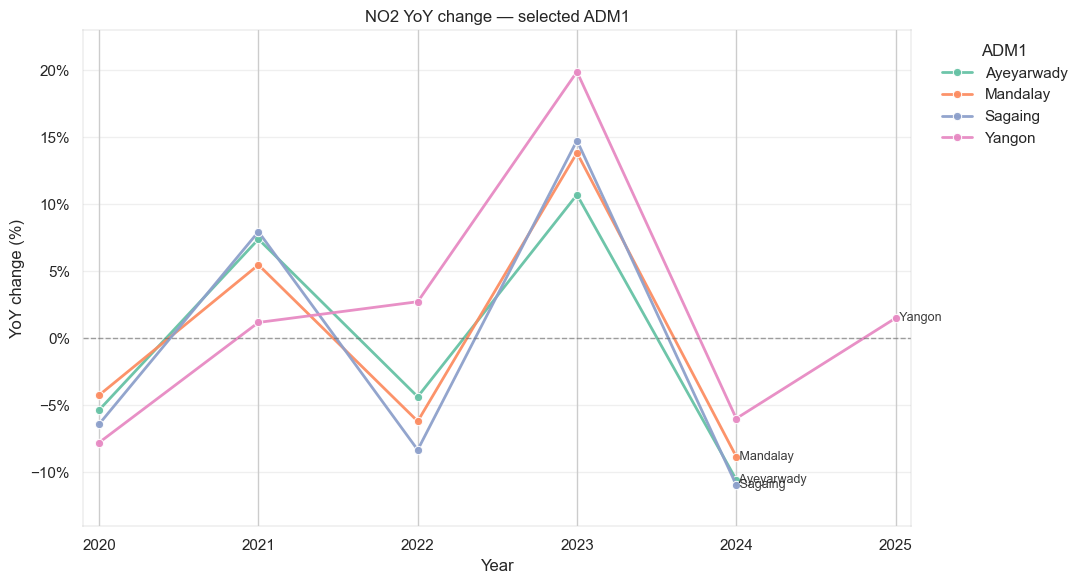

In [ ]:
# Example usage: pick a few ADM1 names
adm1_list = ['Yangon', 'Mandalay', 'Ayeyarwady', 'Sagaing']  # change this list as needed
plot_adm1_yoy(
    mmr_no2_adm1_annual, adm1_names=adm1_list, yoy_col='pct_change_yoy',
    title='NO2 YoY change — selected ADM1', palette='Set2', annotate_last=False
)

In [ ]:
mmr_no2_adm3_annual = mmr_no2_adm3.groupby(['ADM3_PCODE','year', 'ADM3_EN', 'ADM1_EN'])['NO2_column_number_density'].mean().reset_index()

In [ ]:
#mmr_no2_adm3_annual = mmr_adm3.merge(mmr_no2_adm3_annual, on=['ADM3_PCODE', 'ADM3_EN', 'ADM1_EN'], how='inner')
#mmr_no2_adm3_annual[mmr_no2_adm3_annual['ADM1_EN']=='Yangon']

## Trends in Yangon


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_adm3_annual_maps(adm3_gdf, annual_df, admin1_name, year_col='year', value_col='NO2_column_number_density', adm1_name_col='ADM1_EN', adm3_code_col='ADM3_PCODE', adm3_name_col='ADM3_EN', cmap='viridis', per_plot_width=3.8, height=None, ncols=None, show_suptitle=True, dpi=150):
    """
    Single-row grid of annual ADM3 choropleth maps for a given ADM1, with a right-side colorbar.

    - viridis by default
    - all years in one row (unless ncols provided)
    - panel titles show only the year
    - dedicated colorbar axis on the right
    - fixed map extent and zero margins to remove excess whitespace
    - auto height based on geometry aspect if `height` is None
    """
    # Theme
    sns.set_theme(style='white', context='notebook')
    # Filter to ADM1
    g = adm3_gdf[adm3_gdf[adm1_name_col] == admin1_name].copy()
    d = annual_df[annual_df[adm1_name_col] == admin1_name].copy()
    if g.empty or d.empty:
        raise ValueError('No matching rows for the provided ADM1 name.')
    # Merge geometries with values
    plot_df = g[[adm3_code_col, adm3_name_col, adm1_name_col, 'geometry']].merge(
        d[[adm3_code_col, year_col, value_col]], on=adm3_code_col, how='left'
    )
    years = sorted(plot_df[year_col].dropna().unique())
    if len(years) == 0:
        raise ValueError('No years to plot after merge.')
    # Layout: 1 row by default
    if ncols is None:
        ncols = len(years)
    nrows = 1 if ncols >= len(years) else int(np.ceil(len(years) / ncols))
    # Geometry aspect to compute auto height
    xmin, ymin, xmax, ymax = g.total_bounds
    geo_aspect = (ymax - ymin) / max(1e-9, (xmax - xmin))  # avoid divide-by-zero
    if height is None:
        height = per_plot_width * geo_aspect * 1.05  # slight padding
    # Build figure with an extra column for colorbar
    total_cols = ncols + 1
    width = per_plot_width * ncols + 0.8  # add margin space for colorbar
    fig, axes = plt.subplots(
        nrows=nrows, ncols=total_cols,
        figsize=(width, height * nrows),
        gridspec_kw={'width_ratios': [1]*ncols + [0.05]},
        dpi=dpi
    )
    if not hasattr(axes, 'flatten'):
        axes = np.array([axes])
    axes = axes.flatten()
    axes_main = axes[:-1]
    cax = axes[-1]
    # Consistent color scale
    vmin = np.nanmin(plot_df[value_col].values)
    vmax = np.nanmax(plot_df[value_col].values)
    # Fixed extent from geometry bounds
    for i, yr in enumerate(years):
        ax = axes_main[i]
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'{int(yr)}', fontsize=11)
        sub = plot_df[plot_df[year_col] == yr]
        sub.plot(
            column=value_col, cmap=cmap, linewidth=0.3, edgecolor='white',
            vmin=vmin, vmax=vmax, legend=False, ax=ax
        )
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.margins(0)
        ax.axis('off')
    # Hide any unused main axes
    for j in range(len(years), len(axes_main)):
        axes_main[j].axis('off')
    # Right-side colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label(value_col)
    cax.set_title('')  # no title on cbar axis
    # Optional suptitle
    if show_suptitle:
        fig.suptitle(f'Annual {value_col} by ADM3 — {admin1_name}', y=1.02, fontsize=13)
    fig.tight_layout()
    plt.show()

In [ ]:
mmr_no2_adm3_annual = compute_yoy_annual(mmr_no2_adm3_annual, 'NO2_column_number_density', group_cols=['ADM3_PCODE', 'ADM3_EN', 'ADM1_EN'])

In [ ]:
yangon_adm3_annual = mmr_no2_adm3_annual[mmr_no2_adm3_annual['ADM1_EN']=='Yangon']

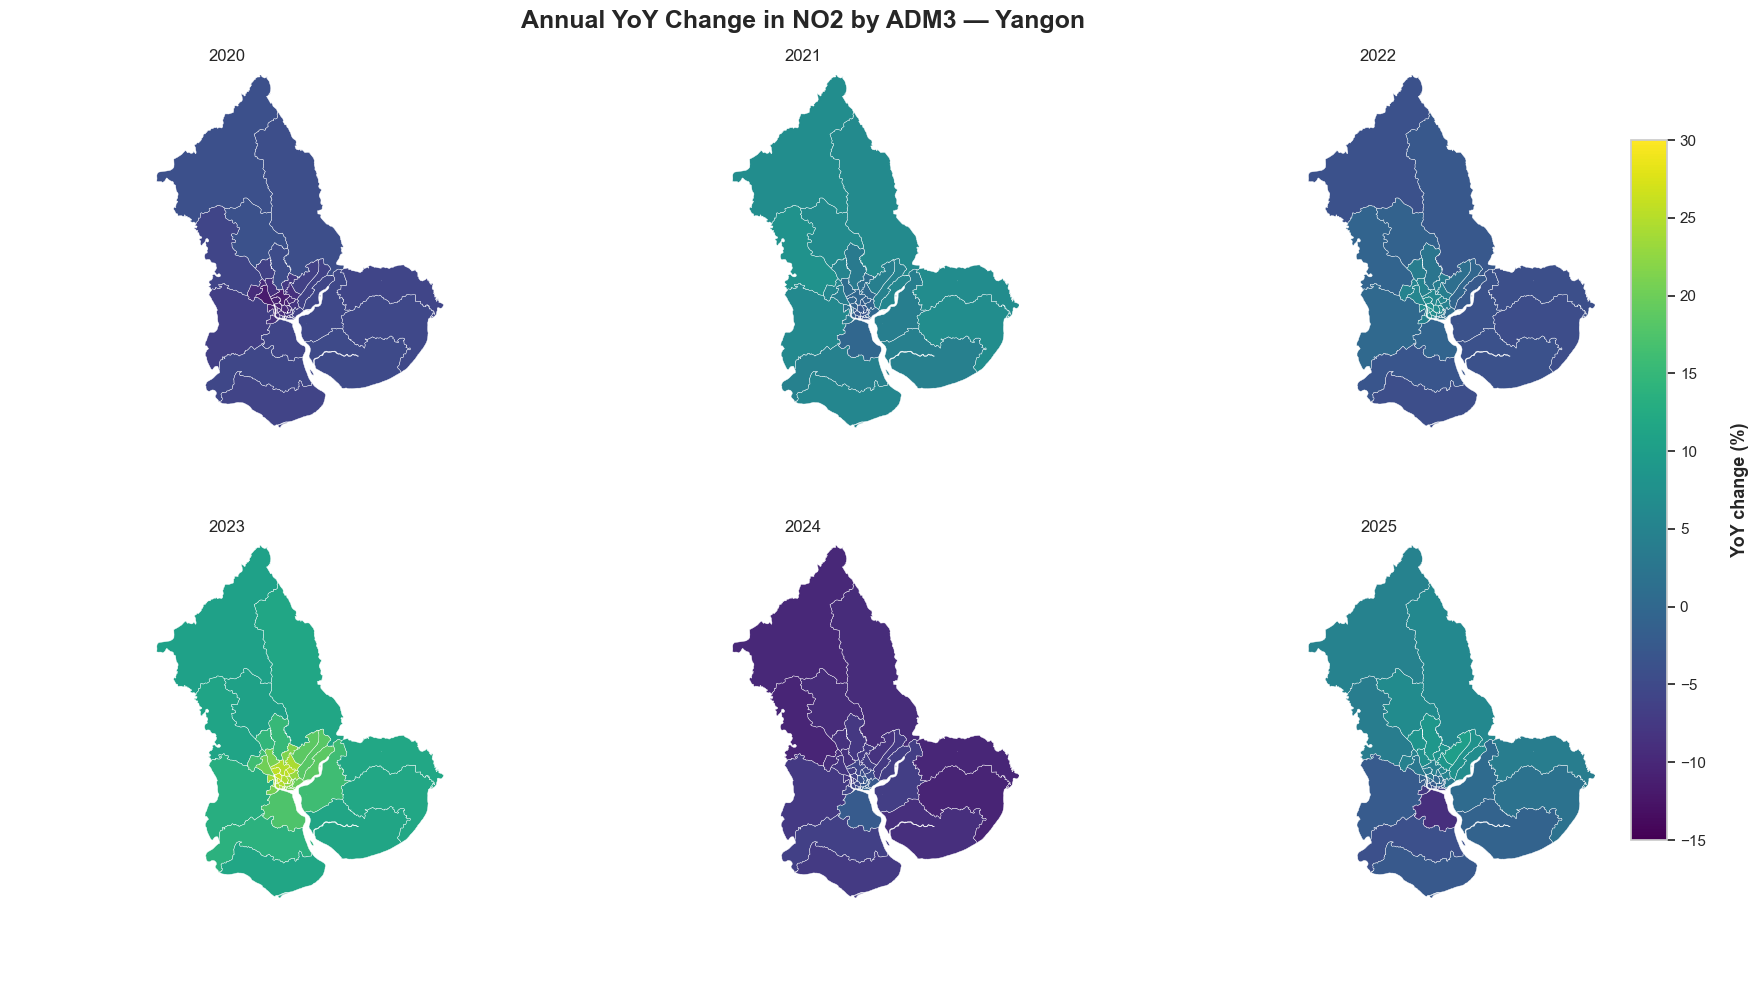

In [ ]:
# Create a cleaner 2x3 grid with proper sizing and shared colorbar
import warnings
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
ax = axs.flatten()

# Get Yangon geometry bounds for consistent map extent
yangon_geom = mmr_adm3[mmr_adm3['ADM1_EN'] == 'Yangon']
bounds_xmin, bounds_ymin, bounds_xmax, bounds_ymax = yangon_geom.total_bounds

# Define tighter lat/lon limits for better map focus
lon_min, lon_max = 95, 98  # Longitude limits
lat_min, lat_max = 16, 17.9  # Latitude limits

# Use the more restrictive of geometry bounds vs manual limits
xmin = max(bounds_xmin, lon_min)
xmax = min(bounds_xmax, lon_max)
ymin = max(bounds_ymin, lat_min)
ymax = min(bounds_ymax, lat_max)

# Plot each year with consistent styling
for idx, year in enumerate([2020, 2021, 2022, 2023, 2024, 2025]):
    subset = yangon_adm3_annual[yangon_adm3_annual['year'] == year]
    
    # Plot with proper map extent
    subset.plot(
        ax=ax[idx], 
        column='pct_change_yoy', 
        cmap='viridis',
        legend=False, 
        vmin=-15, 
        vmax=30,
        linewidth=0.3,
        edgecolor='white'
    )
    
    # Set consistent map extent and styling with lat/lon limits
    ax[idx].set_xlim(xmin, xmax)
    ax[idx].set_ylim(ymin, ymax)
    ax[idx].set_aspect('equal')
    ax[idx].axis('off')
    ax[idx].set_title(f'{year}', fontsize=12, pad=10)

# Add a bold, centered title to the chart itself
fig.suptitle('Annual YoY Change in NO2 by ADM3 — Yangon', fontsize=18, fontweight='bold', y=0.98)

# Add shared colorbar even further outside the chart limits (right of the maps)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=-15, vmax=30))
sm.set_array([])
# Place colorbar further outside the axes using fig.add_axes
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('YoY change (%)', fontsize=13, fontweight='bold', labelpad=18)
# No title for the colorbar axis
cbar.ax.set_title('')

# Suppress tight_layout warning
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.tight_layout()
plt.show()